In [1]:
from PINN.pinn_solver import PINNSolver
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd

from PIL import Image


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


DTYPE = 'float32'
tf.random.set_seed(12345)
np.random.seed(12345)


class SPINN(PINNSolver):
    def __init__(self, x_r, u_r, y_r, s1, s2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Store Model Variables
        self.K = 1.0
        self.tau = 2.0
        # Store Model Constants

        # Store collocation points
        self.x_r = x_r
        self.u = u_r
        self.y_r = y_r
        self.s1 = s1
        self.s2 = s2
        self.dt = 1
        self.files = []
        
    @tf.function
    def get_residual_loss(self):
 
        y = self.model(self.x_r)
            
        return self.residual_function(self.u, y)

    def residual_function(self, u, y_nn):
        """Residual of the ODE"""
        y = (y_nn+1)/2 * (self.s2.data_max_ - self.s2.data_min_)+self.s2.data_min_

        y_t = (y[1:]-y[:-1]) / self.dt
        yn = y[0:-1]
        un = u[0:-1]
        res = self.tau * y_t + yn - self.K * un

        return 1*res

    def callback(self, *args):
        
        path = "figures/"

        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss)
                  )
            
        y_meas = self.y_r[300:600]
        y_nn = self.model(self.x_r[300:600])
        y_meas = self.s2.inverse_transform(y_meas)
        y_nn = self.s2.inverse_transform(y_nn)


        plt.figure(0, figsize=(8,4))
#         plt.subplot(2,1,1)
        plt.plot(y_nn,'r-',label='LSTM')
        plt.plot(y_meas,'b--',label='Measured')
        plt.ylim([0,2])
        plt.xlim([0,len(y_nn)])
        plt.title('LSTM-Onestep model Validation',fontsize=15)
        plt.ylabel("T1", fontsize=13)
        plt.legend(loc=1,fontsize=13)
        plt.text(10,1.75,"Training step: %i"%(self.iter+1),fontsize="xx-large",color="k")
        plt.savefig(path + "animation{}.png".format(self.iter), bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=100, facecolor="white")
        plt.clf()
        plt.close()

        self.files.append(path + "animation{}.png".format(self.iter))
            
        self.hist.append(self.current_loss)
        self.iter += 1


In [2]:
plt.figure(0, figsize=(8,4))

plt.text(1.065,0.7,"Training step: %i"%(1),fontsize="xx-large",color="k")
plt.savefig("animation{}.png".format(1),bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=100, facecolor="white")
plt.clf()
plt.close()

In [3]:
# Load Data
data1 = pd.read_pickle('open_loop_data_SISO-test.pkl')
data2 = pd.read_pickle('open_loop_data_SISO.pkl')

# data set 3 for animation


window = 5

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
s1.data_max_ = np.array([2,2])
s1.data_min_ = np.array([0,0])
s1.min_ = np.array([-1,-1])
s1.max_ = np.array([1,1])
s1.data_range_ = np.array([2,2])
s1.scale_ = np.array([1,1])
Xs1 = s1.transform(data1[['u','y']].to_numpy())
Xs2 = s1.transform(data2[['u','y']].to_numpy())


s2 = MinMaxScaler(feature_range=(-1,1))
s2.data_max_ = np.array([2])
s2.data_min_ = np.array([0])
s2.data_range_ = np.array([2])
s2.min_ = np.array([-1])
s2.max_ = np.array([1])
s2.scale_ = np.array([1])
Ys1 = s2.transform(data1[['y']].to_numpy())
Ys2 = s2.transform(data2[['y']].to_numpy())

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param.pkl', 'wb'))

nstep = Xs1.shape[0]
val_ratio = 0.05
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print("Training:",cut_index, ", Validation:", nstep-cut_index)
Xs_train1 = Xs1[0:cut_index]
Ys_train1 = Ys1[0:cut_index]
Xs_val1 = Xs1[cut_index:]
Ys_val1 = Ys1[cut_index:]

X_train1 = []
Y_train1 = []
for i in range(window,len(Xs_train1)):
    X_train1.append(Xs_train1[i-window:i,:])
    Y_train1.append(Ys_train1[i])

X_val1 = []
Y_val1 = []
for i in range(window,len(Xs_val1)):
    X_val1.append(Xs_val1[i-window:i,:])
    Y_val1.append(Ys_val1[i])

# Reshape data to format accepted by LSTM
X_train1, Y_train1 = np.array(X_train1), np.array(Y_train1)
X_val1, Y_val1 = np.array(X_val1), np.array(Y_val1)


Training: 80 , Validation: 1520


/var/folders/cp/p82kw9zd4psdb4vl1wp3x09m0000gn/T/ipykernel_65744/3262955131.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set


In [4]:
nstep = Xs2.shape[0]
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print("Training:",cut_index, ", Validation:", nstep-cut_index)
Xs_train2 = Xs2[0:cut_index]
Ys_train2 = Ys2[0:cut_index]
Xs_val2 = Xs2[cut_index:]
Ys_val2 = Ys2[cut_index:]

X_train2 = []
Y_train2 = []
for i in range(window,len(Xs_train2)):
    X_train2.append(Xs_train2[i-window:i,:])
    Y_train2.append(Ys_train2[i])

X_val2 = []
Y_val2 = []
for i in range(window,len(Xs_val2)):
    X_val2.append(Xs_val2[i-window:i,:])
    Y_val2.append(Ys_val2[i])

# Reshape data to format accepted by LSTM
X_train2, Y_train2 = np.array(X_train2), np.array(Y_train2)
X_val2, Y_val2 = np.array(X_val2), np.array(Y_val2)


Training: 800 , Validation: 800


/var/folders/cp/p82kw9zd4psdb4vl1wp3x09m0000gn/T/ipykernel_65744/4162911782.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set


In [5]:
# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train1.shape[1],X_train1.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=Y_train1.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)


u_r = data2["u"].to_numpy()[window:Xs_train2.shape[0],None]
u_r = tf.convert_to_tensor(u_r, DTYPE)


solver = SPINN(model=model_lstm, x_r=X_train2,u_r=u_r, y_r=Y_train2, s1=s1, s2=s2, is_pinn=True)

# # Choose step sizes aka learning rate
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-3, 1e-4, 1e-5])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam()

X_train1 = tf.convert_to_tensor(X_train1, DTYPE)
Y_train1 = tf.convert_to_tensor(Y_train1, DTYPE)



2022-05-25 13:52:43.414438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 13:52:43.414558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [6]:
# PINN On or Off
solver.is_pinn = True
solver.solve_with_tf_optimizer(optim, X_train1, Y_train1, n_step=300)

solver.solve_with_scipy_optimizer(X_train1, Y_train1, method='L-BFGS-B')

2022-05-25 13:52:49.994510: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-25 13:52:50.011580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:52:50.570063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:52:50.645443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:52:50.704729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:52:50.826447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:52:50.959570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

It 00000: loss = 2.89504141e-01
It 00010: loss = 1.24838531e-01
It 00020: loss = 9.33353007e-02
It 00030: loss = 7.19683319e-02
It 00040: loss = 5.78906089e-02
It 00050: loss = 4.20815758e-02
It 00060: loss = 2.92046778e-02
It 00070: loss = 1.98742915e-02
It 00080: loss = 1.33319423e-02
It 00090: loss = 8.23138002e-03
It 00100: loss = 4.08995990e-03
It 00110: loss = 1.36913219e-03
It 00120: loss = 5.40818670e-04
It 00130: loss = 3.79832898e-04
It 00140: loss = 2.06597804e-04
It 00150: loss = 1.53807530e-04
It 00160: loss = 1.23205988e-04
It 00170: loss = 9.71793997e-05
It 00180: loss = 8.16839383e-05
It 00190: loss = 6.98521399e-05
It 00200: loss = 6.08872979e-05
It 00210: loss = 5.37622145e-05
It 00220: loss = 4.78517613e-05
It 00230: loss = 4.28976164e-05
It 00240: loss = 3.86690554e-05
It 00250: loss = 3.50337505e-05
It 00260: loss = 3.18899693e-05
It 00270: loss = 2.91619835e-05
It 00280: loss = 2.67886317e-05
It 00290: loss = 2.47198805e-05


2022-05-25 13:54:07.457239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:07.858290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:07.911164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:07.962740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:08.105271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:08.578057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:08.696858: I tensorflow/core/grappler/optimizers/cust

It 00300: loss = 2.28685967e-05


      fun: 2.2622176402364857e-05
 hess_inv: <202101x202101 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.94057622e-07, -9.99649501e-07, -1.48694517e-06, ...,
       -6.19252387e-06,  5.14463682e-06, -1.71041465e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 7
      nit: 5
     njev: 7
   status: 1
  success: False
        x: array([ 0.04035236, -0.10426176,  0.03141823, ...,  0.2587426 ,
        0.09819699, -0.00127639])

In [7]:
solver.loss2

<tf.Tensor: shape=(), dtype=float32, numpy=2.2622176e-05>

In [8]:
solver.hist

[0.28950414,
 0.2673823,
 0.24533226,
 0.22239299,
 0.19834964,
 0.17382981,
 0.15054375,
 0.13140027,
 0.11995643,
 0.119536154,
 0.12483853,
 0.12313489,
 0.11317475,
 0.10143962,
 0.09317835,
 0.08984339,
 0.09019673,
 0.0921287,
 0.09385217,
 0.09434494,
 0.0933353,
 0.09110448,
 0.08825268,
 0.085460074,
 0.08323253,
 0.08167479,
 0.08043744,
 0.07896842,
 0.076931424,
 0.07444508,
 0.07196833,
 0.06997259,
 0.06865906,
 0.0678796,
 0.0672572,
 0.06640043,
 0.06508911,
 0.06335201,
 0.06141634,
 0.059553485,
 0.05789061,
 0.05631683,
 0.05460617,
 0.052681845,
 0.050735366,
 0.049051136,
 0.04772106,
 0.04654429,
 0.045225713,
 0.04367714,
 0.042081576,
 0.040632498,
 0.039267957,
 0.03779555,
 0.036248364,
 0.0348762,
 0.03375321,
 0.0326546,
 0.03143843,
 0.030253345,
 0.029204678,
 0.028140564,
 0.026985759,
 0.025909549,
 0.024973959,
 0.024038851,
 0.023094403,
 0.022259181,
 0.021488925,
 0.020675294,
 0.019874291,
 0.019139497,
 0.018401664,
 0.017653301,
 0.016966948,
 0.0

In [9]:
#%% Save LSTM model file
solver.model.save('PINN_FOPDT_onestep_LSTM_pinn_on.h5')

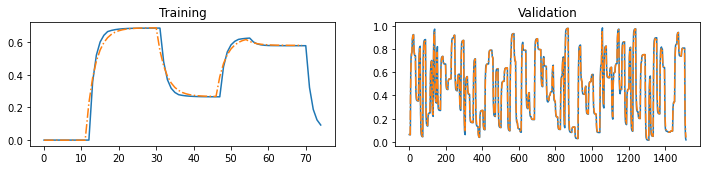

In [10]:
# Training results
yp_train1 = solver.model(X_train1)
y_pinn_train1 = s2.inverse_transform(yp_train1)

yp_val1 = solver.model(X_val1)
y_pinn_val1 = s2.inverse_transform(yp_val1)


plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.gca().set_title('Training')
plt.plot(y_pinn_train1)
plt.plot(data1["y"].to_numpy()[window:y_pinn_train1.shape[0]], '-.')


plt.subplot(2,2,2)
plt.gca().set_title('Validation')
plt.plot(y_pinn_val1)
plt.plot(data1["y"].to_numpy()[y_pinn_train1.shape[0]+window+window:], '-.')


plt.show()

## Using predicted values to predict next step

In [11]:
Xsq = Xs2.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys2.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):] = solver.model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs2.shape[1] - Ys2.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_val_lstm = Ytu

Ym_val2 = s2.inverse_transform(Y_val2)

2022-05-25 13:54:11.740042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:11.843498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:11.889006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 13:54:11.920260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


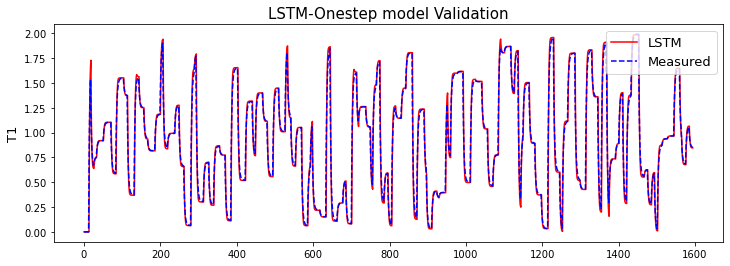

In [12]:
Y_val2 = data2[['y']].to_numpy()[window:]

plt.figure(0, figsize=(12,4))
# plt.subplot(2,1,1)
plt.plot(Ytu_val_lstm[window:],'r-',label='LSTM')
plt.plot(Y_val2,'b--',label='Measured')
plt.title('LSTM-Onestep model Validation',fontsize=15)
plt.ylabel("T1", fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.show()

In [13]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
save_gif_PIL("pinn_on.gif", solver.files, fps=50, loop=0)    